# 基本思想

Inception模块的核心思想就是将不同的卷积层通过并联的方式结合在一起，经过不同卷积层处理的结果矩阵在深度这个维度拼接起来，形成一个更深的矩阵。Inception模块可以反复叠堆形成更大的网络，它可以对网络的深度和宽度进行高效的扩充，在提升深度学习网络准确率的同时防止过拟合现象的发生。Inception模块的优点是可以对尺寸较大的矩阵先进行降维处理的同时，在不同尺寸上对视觉信息进行聚合，方便从不同尺度对特征进行提取。

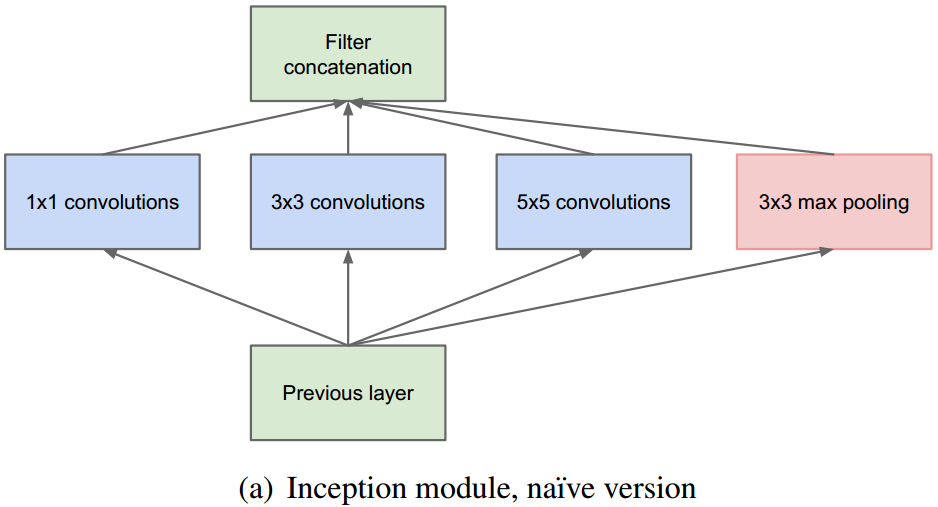

上图为Inception模块的原始版本：Inception模块中包含卷积操作，但是不同于传统卷积神经网络，此模块中可以设置多个通路，每个通路可以是不同的操作，相同的操作也可以设置不同的kernel size和stride。不同的卷积尺寸提供了不同的感受野，可以做不同级别上的特征提取，池化操作本身有提取特征的作用，而且因为没有参数不会产生过拟合，所以池化操作也作为此模块的一个通路。

此模块采取了几个措施来使密集的成分能够近似最优的稀疏结构。首先，在同一层中采用了不同大小的卷积核来提取上一层的特征，并在最后进行拼接。这样意味着在同一层中网络就能从感受不同大小的图像局部区域，并对不同尺度的特征进行融合。卷积核大小普遍采用1、3和5，再设定卷积步长为1，只要图像的填充值(padding)分别设置为0、1、2，那么卷积之后便可以得到相同维度的特征，之后便可以将这些特征值直接拼接在一起。此外，由于池化层在很多网络中都起到相当大的作用，因此在Inception模块中也嵌入了这一操作。最后由于神经网络随着深度的增加所提取的特征也逐渐抽象，每个特征涉及到更大的感受区域，因此在网络的深层应该逐渐增加大尺寸卷积核的比例。

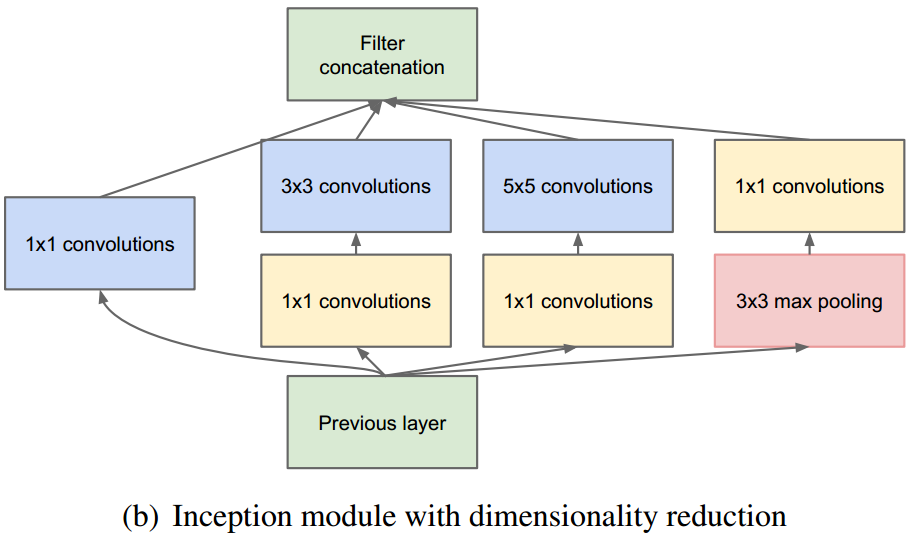

上图为降维(dimension reductions)后的最终Inception-v1版本：优点：(1).同时使用不同尺寸的卷积核可以提取到种类更加丰富的特征；(2).使用稀疏矩阵分解为密集矩阵计算的原理，增加了收敛速度。

由于5\*5的卷积核仍然会带来巨大的计算量，考虑到这一点，此模块加入了1\*1卷积核来进行降维即限制输入通道数量。

Inception-v1中使用了多个1\*1卷积核，其作用：(1).在大小相同的感受野上叠加更多的卷积核，可以让模型学习到更加丰富的特征。传统的卷积层的输入数据只和一种尺寸的卷积核进行运算，而Inception-v1结构是Network in Network(NIN)，就是先进行一次普通的卷积运算(比如5\*5)，经过激活函数(比如ReLU)输出之后，然后再进行一次1\*1的卷积运算，这个后面也跟着一个激活函数。1\*1的卷积操作可以理解为feature maps个神经元都进行了一个全连接运算。(2).使用1\*1的卷积核可以对模型进行降维，减少运算量。当一个卷积层输入了很多feature maps的时候，这个时候进行卷积运算计算量会非常大，如果先对输入进行降维操作，feature maps减少之后再进行卷积运算，运算量会大幅减少。

Inception模块中，1\*1、3\*3、5\*5的卷积核并不是固定的，可以根据实验进行调整。

下图可以形象地说明Inception-v1模块内是如何能够拼接在一起的：

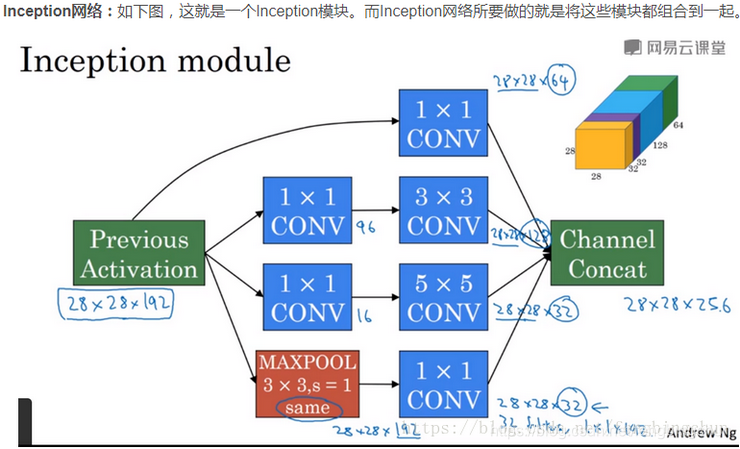

# 1\*1卷积核

## 跨通道的特征整合

如果当前层和下一层都只有一个通道那么1×1卷积核确实没什么作用，但是如果它们分别为m层和n层的话，1×1卷积核可以起到一个跨通道聚合的作用，所以进一步可以起到降维（或者升维）的作用，起到减少参数的目的。 

这里通过一个例子来直观地介绍1x1卷积。输入6x6x1的矩阵，这里的1x1卷积形式为1x1x1，即为元素2，输出也是6x6x1的矩阵。但输出矩阵中的每个元素值是输入矩阵中每个元素值x2的结果。

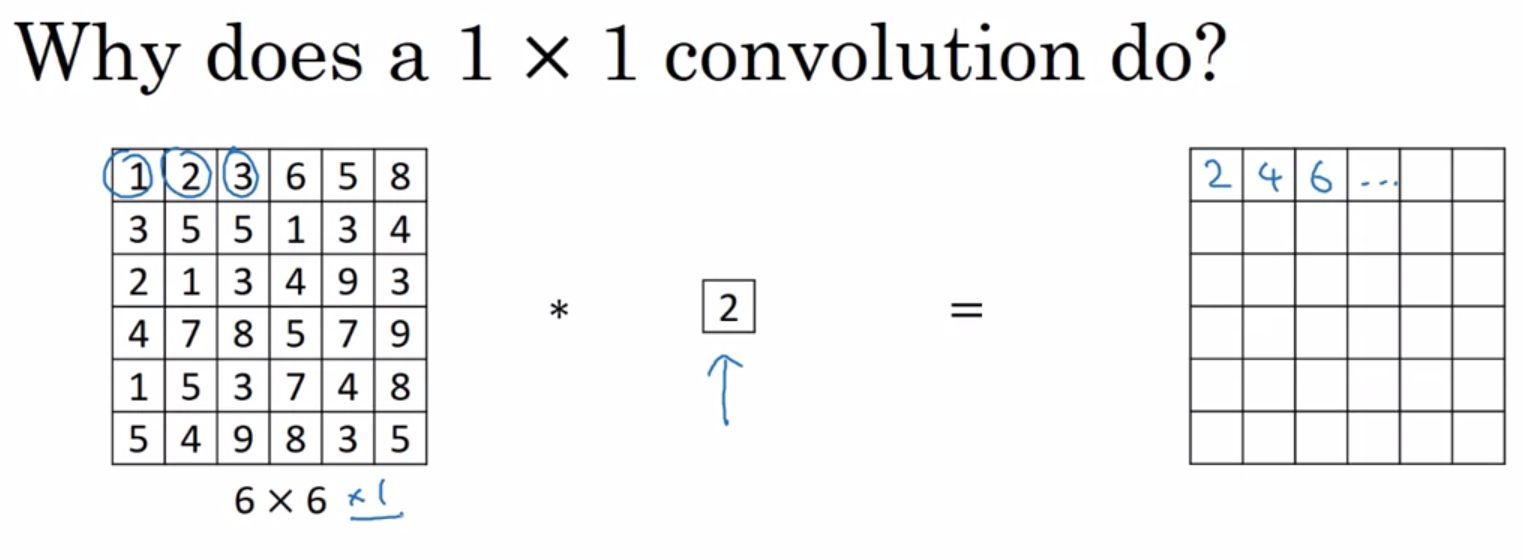

上述情况，并没有显示1x1卷积的特殊之处，那是因为上面输入的矩阵channel为1，所以1x1卷积的channel也为1。这时候只能起到升维的作用。这并不是1x1卷积的魅力所在。

让我们看一下真正work的示例。当输入为6x6x32时，1x1卷积的形式是1x1x32，当只有一个1x1卷积核的时候，此时输出为6x6x1。此时便可以体会到1x1卷积的实质作用：降维。当1x1卷积核的个数小于输入channels数量时，即降维[3]。

注意，下图中第二行左起第二幅图像中的黄色立方体即为1x1x32卷积核，而第二行左起第一幅图像中的黄色立方体即是要与1x1x32卷积核进行叠加运算的区域。

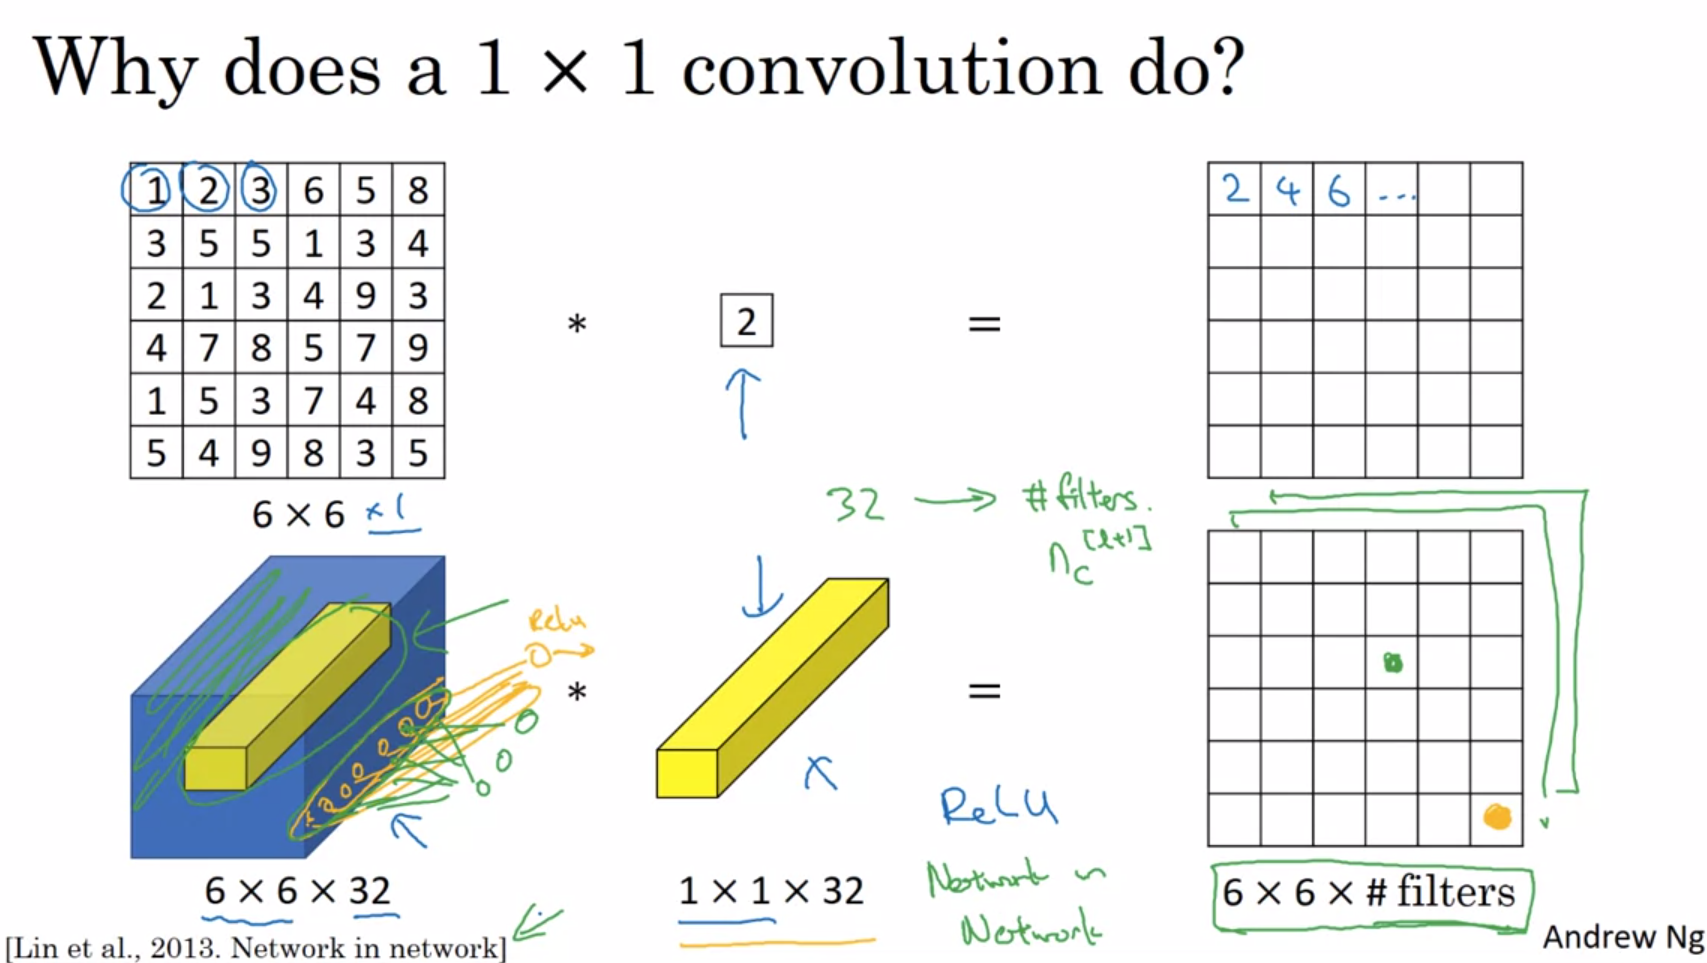

其实1x1卷积，可以看成一种全连接（full connection）。

注：1x1卷积一般只改变输出通道数（channels），而不改变输出的宽度和高度

## 降维/升维

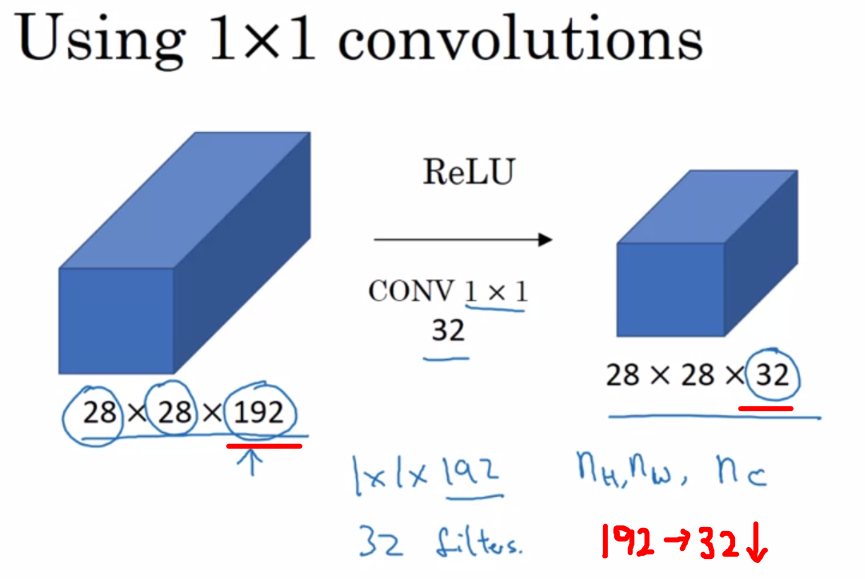

## 加非线性

1\*1卷积核，可以在保持feature map尺度不变的（即不损失分辨率）的前提下大幅增加非线性特性（利用后接的非线性激活函数），把网络做的很deep。

备注：一个filter对应卷积后得到一个feature map，不同的filter(不同的weight和bias)，卷积以后得到不同的feature map，提取不同的特征，得到对应的specialized neuron。

## 跨通道信息交互（channal 的变换）

使用1x1卷积核，实现降维和升维的操作其实就是channel间信息的线性组合变化，3x3，64channels的卷积核后面添加一个1x1，28channels的卷积核，就变成了3x3，28channels的卷积核，原来的64个channels就可以理解为跨通道线性组合变成了28channels，这就是通道间的信息交互。

## 减少计算量

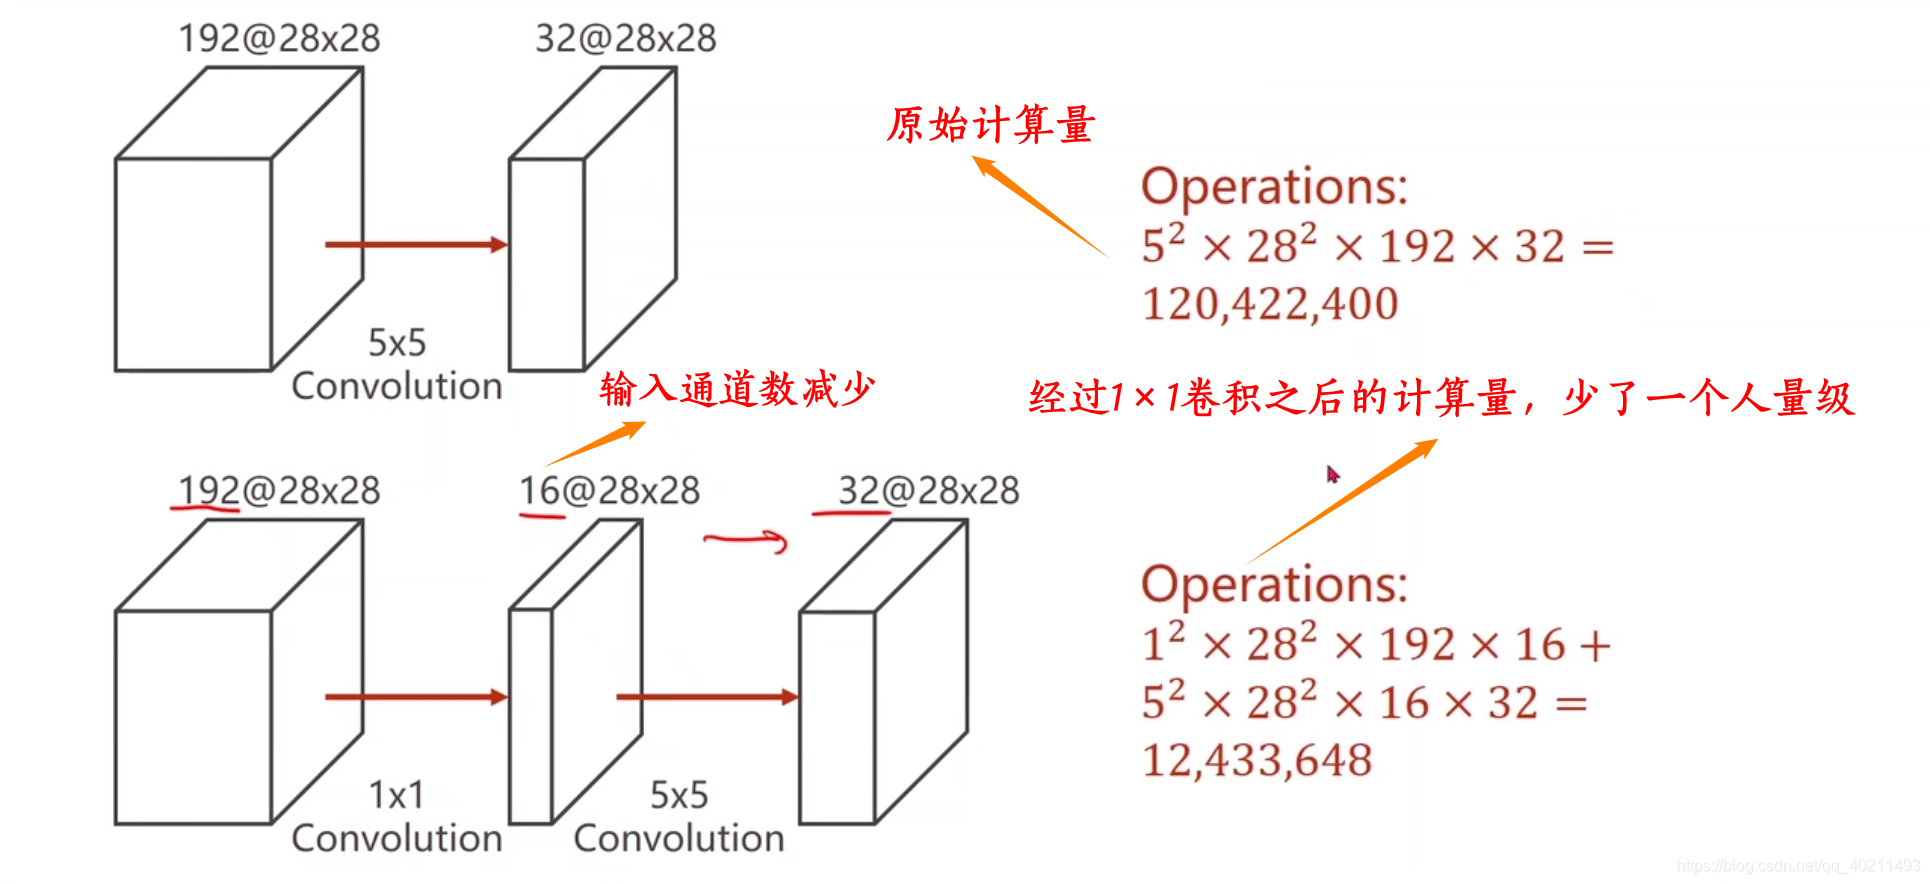